In [8]:
# Run this in a Colab code cell (prefix with !)
!apt-get update -qq
!apt-get install -y openjdk-11-jdk-headless -qq
!pip install -q pyspark==3.3.2 findspark kaggle matplotlib pandas scikit-learn


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Selecting previously unselected package java-common.
(Reading database ... 125081 files and directories currently installed.)
Preparing to unpack .../java-common_0.72build2_all.deb ...
Unpacking java-common (0.72build2) ...
Selecting previously unselected package libpcsclite1:amd64.
Preparing to unpack .../libpcsclite1_1.9.5-3ubuntu1_amd64.deb ...
Unpacking libpcsclite1:amd64 (1.9.5-3ubuntu1) ...
Selecting previously unselected package openjdk-11-jre-headless:amd64.
Preparing to unpack .../openjdk-11-jre-headless_11.0.28+6-1ubuntu1~22.04.1_amd64.deb ...
Unpacking openjdk-11-jre-headless:amd64 (11.0.28+6-1ubuntu1~22.04.1) ...
Selecting previously unselected package ca-certificates-java.
Preparing to unpack .../ca-certificates-java_20190909ubuntu1.2_all.deb ...
Unpacking ca-certificates-java (20190909u

In [9]:
import os, sys
os.environ['JAVA_HOME'] = '/usr/lib/jvm/java-11-openjdk-amd64'
import pyspark
print("Python:", sys.version.splitlines()[0])
print("PySpark:", pyspark.__version__)


Python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
PySpark: 3.5.1


In [10]:
# Option A: upload directly (interactive)
from google.colab import files
uploaded = files.upload()  # choose your CSV when prompted
csv_path = list(uploaded.keys())[0]

# Option B: or mount Google Drive and set path
# from google.colab import drive
# drive.mount('/content/drive')
# csv_path = '/content/drive/MyDrive/path/to/online_course_engagement_data.csv'
print("Using", csv_path)


Saving online_course_engagement_data.csv to online_course_engagement_data.csv
Using online_course_engagement_data.csv


In [11]:
import findspark
findspark.init()

from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .master('local[*]') \
    .appName('MOOC-Completion-SVM') \
    .config('spark.driver.memory','6g') \
    .getOrCreate()

print(spark)


In [12]:
csv_path = csv_path  # from upload / drive step
df = spark.read.csv(csv_path, header=True, inferSchema=True)
print("Rows:", df.count(), "Columns:", len(df.columns))
df.printSchema()
df.show(5, truncate=False)


Rows: 9000 Columns: 9
root
 |-- UserID: integer (nullable = true)
 |-- CourseCategory: string (nullable = true)
 |-- TimeSpentOnCourse: double (nullable = true)
 |-- NumberOfVideosWatched: integer (nullable = true)
 |-- NumberOfQuizzesTaken: integer (nullable = true)
 |-- QuizScores: double (nullable = true)
 |-- CompletionRate: double (nullable = true)
 |-- DeviceType: integer (nullable = true)
 |-- CourseCompletion: integer (nullable = true)

+------+--------------+------------------+---------------------+--------------------+------------------+------------------+----------+----------------+
|UserID|CourseCategory|TimeSpentOnCourse |NumberOfVideosWatched|NumberOfQuizzesTaken|QuizScores        |CompletionRate    |DeviceType|CourseCompletion|
+------+--------------+------------------+---------------------+--------------------+------------------+------------------+----------+----------------+
|5618  |Health        |29.979719346137415|17                   |3                   |50.3656559

In [13]:
from pyspark.sql.functions import col, sum as _sum
null_counts = df.select([_sum(col(c).isNull().cast('int')).alias(c) for c in df.columns])
null_counts.show(truncate=False)

# If any nulls in numeric cols, we will impute later. For this dataset preview there were no nulls.


+------+--------------+-----------------+---------------------+--------------------+----------+--------------+----------+----------------+
|UserID|CourseCategory|TimeSpentOnCourse|NumberOfVideosWatched|NumberOfQuizzesTaken|QuizScores|CompletionRate|DeviceType|CourseCompletion|
+------+--------------+-----------------+---------------------+--------------------+----------+--------------+----------+----------------+
|0     |0             |0                |0                    |0                   |0         |0             |0         |0               |
+------+--------------+-----------------+---------------------+--------------------+----------+--------------+----------+----------------+



In [14]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler

label_col = 'CourseCompletion'
cat_cols = ['CourseCategory']
num_cols = ['TimeSpentOnCourse','NumberOfVideosWatched','NumberOfQuizzesTaken','QuizScores','CompletionRate']
# DeviceType is numeric (0/1) and will be included in num_features
num_cols = ['DeviceType'] + num_cols

# index + one-hot encoding for categories
indexers = [StringIndexer(inputCol=c, outputCol=c + "_idx", handleInvalid='keep') for c in cat_cols]
encoders = [OneHotEncoder(inputCol=c + "_idx", outputCol=c + "_ohe") for c in cat_cols]

assembler_inputs = [c + "_ohe" for c in cat_cols] + num_cols
assembler = VectorAssembler(inputCols=assembler_inputs, outputCol='features_raw')
scaler = StandardScaler(inputCol='features_raw', outputCol='features', withStd=True, withMean=False)

preprocessing_stages = indexers + encoders + [assembler, scaler]


In [15]:
from pyspark.ml.classification import LinearSVC
from pyspark.ml import Pipeline

svc = LinearSVC(labelCol=label_col, featuresCol='features', maxIter=100, regParam=0.01)
pipeline = Pipeline(stages=preprocessing_stages + [svc])

train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)
print("Train rows:", train_df.count(), "Test rows:", test_df.count())

model = pipeline.fit(train_df)
predictions = model.transform(test_df)
predictions.select('UserID', label_col, 'prediction').show(10)


Train rows: 7275 Test rows: 1725
+------+----------------+----------+
|UserID|CourseCompletion|prediction|
+------+----------------+----------+
|     4|               1|       1.0|
|     8|               0|       0.0|
|    10|               1|       1.0|
|    15|               1|       0.0|
|    21|               0|       0.0|
|    26|               1|       1.0|
|    32|               1|       1.0|
|    38|               1|       0.0|
|    51|               0|       0.0|
|    52|               1|       1.0|
+------+----------------+----------+
only showing top 10 rows



In [16]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator_acc = MulticlassClassificationEvaluator(labelCol=label_col, predictionCol='prediction', metricName='accuracy')
evaluator_f1  = MulticlassClassificationEvaluator(labelCol=label_col, predictionCol='prediction', metricName='f1')

acc = evaluator_acc.evaluate(predictions)
f1  = evaluator_f1.evaluate(predictions)
print(f"Accuracy: {acc:.4f}")
print(f"F1-score:  {f1:.4f}")


Accuracy: 0.8064
F1-score:  0.8047


In [19]:
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "false")


In [21]:
from pyspark.sql import functions as F

# --- Confusion Matrix (Spark only) ---
confusion_spark = (
    predictions.groupBy(label_col, 'prediction')
    .count()
    .orderBy(label_col, 'prediction')
)
print("Spark confusion matrix:")
confusion_spark.show()

# --- Accuracy, Precision, Recall, F1 (Spark formulas) ---
TP = confusion_spark.filter((F.col(label_col)==1) & (F.col('prediction')==1)).select('count').collect()
FP = confusion_spark.filter((F.col(label_col)==0) & (F.col('prediction')==1)).select('count').collect()
FN = confusion_spark.filter((F.col(label_col)==1) & (F.col('prediction')==0)).select('count').collect()
TN = confusion_spark.filter((F.col(label_col)==0) & (F.col('prediction')==0)).select('count').collect()

TP = TP[0][0] if TP else 0
FP = FP[0][0] if FP else 0
FN = FN[0][0] if FN else 0
TN = TN[0][0] if TN else 0

accuracy  = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall    = TP / (TP + FN) if (TP + FN) > 0 else 0
f1        = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

print(f"\nMetrics (Spark Computed):")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}")


Spark confusion matrix:
+----------------+----------+-----+
|CourseCompletion|prediction|count|
+----------------+----------+-----+
|               0|       0.0|  881|
|               0|       1.0|  133|
|               1|       0.0|  201|
|               1|       1.0|  510|
+----------------+----------+-----+


Metrics (Spark Computed):
Accuracy:  0.8064
Precision: 0.7932
Recall:    0.7173
F1-score:  0.7533


In [23]:
# Disable Arrow to avoid Py4JError
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "false")

# Select only the columns we need
out_df = predictions.select('UserID', label_col, 'prediction')

# Write directly to a single CSV file
output_dir = "/content/predictions_out"
(
    out_df.coalesce(1)        # put everything in one file
    .write
    .mode("overwrite")
    .option("header", True)
    .csv(output_dir)
)

print(f"Predictions saved to folder: {output_dir}")


Predictions saved to folder: /content/predictions_out


In [24]:
# Find the part file and download it
import glob, shutil
from google.colab import files

# find the generated part file inside the folder
part_file = glob.glob("/content/predictions_out/part-*.csv")[0]
shutil.move(part_file, "/content/predictions.csv")

# download to your local system
files.download("/content/predictions.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

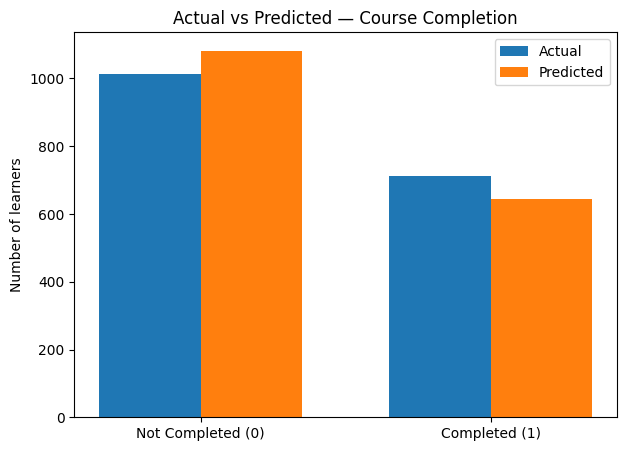

In [26]:
import matplotlib.pyplot as plt
from pyspark.sql import functions as F

# Disable Arrow everywhere
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "false")

# Count actual and predicted values directly in Spark
actual_counts = (
    predictions.groupBy(label_col)
    .count()
    .orderBy(label_col)
    .collect()
)
pred_counts = (
    predictions.groupBy('prediction')
    .count()
    .orderBy('prediction')
    .collect()
)

# Convert to Python lists
actual_vals = [r['count'] for r in actual_counts]
pred_vals = [r['count'] for r in pred_counts]

labels = ['Not Completed (0)', 'Completed (1)']
x = range(len(labels))
width = 0.35

# Plot using Matplotlib
plt.figure(figsize=(7,5))
plt.bar([i - width/2 for i in x], actual_vals, width=width, label='Actual')
plt.bar([i + width/2 for i in x], pred_vals, width=width, label='Predicted')
plt.xticks(x, labels)
plt.ylabel('Number of learners')
plt.title('Actual vs Predicted — Course Completion')
plt.legend()
plt.show()
